<head>
<h1 style="text-align:right"> *Techniques Avancées d'Apprentissage - ENSAE ParisTech - 2017/2018*</h1>  
<h1 style="text-align:center">Charles Dognin - Samuel Ritchie</h1>
<h3 style="text-align:center"><span style="color: #fb4141">Music and Image generation with Variational Auto-Encoders</span></h3> 
</head>


This Notebook aims at trying to generate music (and in a first time images) thanks to a particular type of generative model : Variational Auto-Encoders. This method was first described by Diederik P. Kingma and Max Welling in *Auto-Encoding Variational Bayes* (https://arxiv.org/pdf/1312.6114.pdf) and today achieves state of the art results along with Generative Adversarial Networks (GANs) in data generation (text, image, music). The code is largely inspired by Keras official implementation of auto-encoders (https://blog.keras.io/building-autoencoders-in-keras.html).

## 0. Import useful packages

In [2]:
import numpy as np
from pathlib import Path
import IPython
from keras import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, History
import numpy as np
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Conv1D, \
    MaxPooling1D, Flatten, BatchNormalization, LeakyReLU, Lambda, Reshape, RepeatVector
from keras.optimizers import Adam, RMSprop
from keras.engine.topology import Input
from keras import backend as K
from IPython.display import Image
import cv2
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
from pathlib import Path
from jyquickhelper import add_notebook_menu
add_notebook_menu()

/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/charlesdognin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Use Keras with associated Tensorflow backend and relevant associated functions

## 1. A few theoretical aspects

We start by giving a few insights on generative models and VAEs. Please refer to the full report in /Deliverables folder for more details.

Basically, a generative model comes down to describing how data is generated in terms of probabilistic model. Two of the most commonly used and efficient approaches are VAEs and GANs. These both methods fundamentally differ in the approach for density estimation : GANs aims at achieving a Nash equilibrium between a Generator and a Discriminator, while VAEs are based on the auto-encoder theory.

Traditional Auto-Encoders are models whose goal are to learn a compressed representation of the data, similarly to the Principal Component Analysis. The autoencoder has two parts: an encoder and a decoder. The encoder encodes the input into a "code" (also called latent space), generally of lower dimension than the input in order to only keep the most important information. While the primary purpose of such models was dimensionality reduction, the rise of deep learning frameworks and interest in generating data made the autoencoder concept be widely used for learning generative models of data.

<img src="images/autoencoder.jpg" >
<figcaption>*Image source : https://blog.keras.io/building-autoencoders-in-keras.html*</figcaption>

Many applications use autoencoder methods, among which dimensionality reduction as already mentioned, and most importantly denoising autoencoders allowing to find the relevant features in a blurred input signal. However, regarding generation of data from the learned representation, they are extremely limited. Indeed, the latent variable does not have a tractable distribution, or said in other terms the latent space may not allow easy interpolation. More precisely, one could say that autoencoders are fine for *replicating* data (thanks to clusters in the latent space), but is not good at *generating* new data because of eventual discontinuities in the latent space, as it can be seen in the following image.

Let x be the data we want to model and z the latent variable (in a lower dimension). In what follows, we will refer to the decoder network distribution modeling as $p_{\theta}(x|z)$ and the encoder one as $q_{\Phi}(z|x)$. Our goal is to learn model parameters in order to maximize the likelihood of training data :

$$ p_{\theta} (x) = \int p_{\theta} (z) p_{\theta} (x|z) dz$$

This problem is completely untractable since it is impossible to integrate over the whole latent space. Using variational inference methods (see report for details), one can lower bound the log-likelihood by a sum of two terms :

$$ 
\log p_{\theta}(x) \geq \mathcal{L}(x, \theta, \Phi) = \mathbb{E}_z \left[ \log p_{\theta}(x|z) \right] - D_{KL} \left( q_{\Phi}(z|x), p_{\theta}(z)\right) \\
 $$

The variational lower-bound is the sum of two terms (in the auto-encoder we only had reconstruction loss) : 
> -  the *reconstruction error* : it is the log-likelihood of the observed $x$ given the latent feature $z$ we have sampled. It is linked to the decoder network performances $p_{x|z}$ 
> -  the second part corresponds to the difference between distributions $p(z)$ we want to estimate and $q(z|x)$ which is used to approximate it. In practice, standard normal distributions will be used. This part checks that the proposal distribution should be like a Gaussian (or any other chosen distribution) and is often called the *regularization term*

<img src="images/latent_space_diff.png" >
<figcaption>*Image source : https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf*</figcaption>

The image above clearly shows to what extent VAEs enable us to sample new image from the latent space, and not only replicate data as auto-encoders do.

## 2. VAE Model

### 2.1. Signal Pre-Processing

#### 2.1.1 Image pre-processing

In [98]:
x_train_img, x_val_img = [], []
p_train = Path("data/train")
p_val = Path("data/val")
data_train = list(p_train.glob("*.jpg"))
data_val = list(p_val.glob("*.jpg"))
data_train = [str(path) for path in data_train]
data_val = [str(path) for path in data_val]

for path in data_train:
    im = cv2.imread(path)
    im = im.astype('float32')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (70, 70)) / 255
    im = np.expand_dims(im, axis=0)
    x_train_img.append(im)
    
for path in data_val:
    im = cv2.imread(path)
    im = im.astype('float32')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (70, 70)) / 255
    im = np.expand_dims(im, axis=0)
    x_val_img.append(im)

x_train_img = np.array(x_train_img)
x_train_img = x_train_img.reshape((len(x_train_img), np.prod(x_train_img.shape[1:])))

x_val_img = np.array(x_val_img)
x_val_img = x_val_img.reshape((len(x_val_img), np.prod(x_val_img.shape[1:])))

#### 2.1.2 Audio pre-processing

In [54]:
x_train_mus =[]
p_train = Path("data/music_train")
data_train = list(p_train.glob("*.wav"))
data_train = [str(path) for path in data_train]

for path in data_train:
    rate, data = wavfile.read(path)
    if len(data.shape) == 2:
        data = data[:,0]
        data = data / 50000.
        data = data[:30000]
        x_train_mus.append(data)

x_train_mus = np.array(x_train_mus)
x_train_mus.shape

/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(10, 30000)

### 2.2 Training algorithm

In [ ]:

class VAE:
    """
    Variational Auto-Encoder class taking as input the training and validation images, as well as the 
    size of the original, intermediate and latent dim, batch_size and epochs.
    """

    def __init__(self, x_train, batch_size, epochs, original_dim, 
                 latent_dim, intermediate_dim):
        self.seed = np.random.seed(32)
        self.x_train = x_train
        self.batch_size = batch_size
        self.epochs = epochs
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.encoder = self.make_encoder()
        self.sampling_layer = self.make_sampling_layer()
        self.decoder = self.make_decoder()
        self.vae_model = self.make_vae(self.sampling_layer, self.encoder, self.decoder)
               
    def fit(self):
        """
        Train the Vae using the Adam Optimizer. 
        """
        
        self.vae_model.fit(self.x_train,
                           epochs=self.epochs,
                           batch_size=self.batch_size)
        
    def predict(self, z_test):
        """
        At test time, we evaluate the VAE's ability to generate a new sample. We can remove the 
        encoder as there is no test image. We sample z from a N(0, I), pass it through the decoder.
        There are no good quantitative metrics, only visual appreciation.
        
        Arguments:
        z_test -- sample from the standard Gaussian distribution to which we apply the trained decoder
        
        Returns:
        pred -- the generated image or music
        """
        
        pred = self.decoder.predict(z_test)
        
        return pred
     
    def make_encoder(self):
        """
        Transform the input into a distribution, composed of the mean and the variance
        
        Returns:
        model -- the encoder model with the object as input and the z_mean and z_sigma 
        as output
        """
        
        enc_input = Input(shape=(self.original_dim,)) # The original image or sound
        # First fully connected layer with a rectified linear unit activation function to only keep the positive parts
        # of the neurons the size is already reduced to intermediate_dim
        x = Dense(self.intermediate_dim, activation='relu')(enc_input) 
        # Twins fully connected layers determining the mean and the variance of the latent distribution
        # of the neurons, the size is further reduced to latent dim
        self.z_mean = Dense(self.latent_dim)(x)
        self.z_sigma = Dense(self.latent_dim)(x)
        model = Model(enc_input, outputs = [self.z_mean, self.z_sigma], name="mlp_encoder")
        
        return model
    
    def make_decoder(self):
        """
        Decodes the latent vector z and match it with the original output
        
        Returns:
        model -- the decoder model with the latent variable as input and the original object as output
        """
        
        dec_input = Input(shape=(self.latent_dim,)) # The input is the latent distribution
        x = Dense(self.intermediate_dim, activation='relu')(dec_input) # First fully connected to decode 
        x = Dense(self.original_dim, activation='sigmoid')(x) # Second fully connected with sigmoid activation
        model = Model(dec_input, x, name="mlp_decoder")
        
        return model
    
    def sampling(self, params):
        """
        Function that uses the learned mean and sigma from the data and return the latent vector z
        This is the re-parametrization trick. Instead of taking (z -> N(z_mean, z_sigma)), we take
        (epsilon -> N(0, I) and z = z_mean + z_sigma * epsilon). 
        
        Arguments:
        z_mean -- the learned mean
        z_sigma -- the learned standard deviation
        
        Returns:
        z -- the latent generated distribution (vector of dimension latent_dim)
        """
        
        z_mean, z_sigma = params 
        epsilon = K.random_normal((self.batch_size, self.latent_dim), 0.0, 1.0) # Epsilon is the random part following
        # a standard Gaussian distribution
        z = z_mean + K.exp(z_sigma / 2) * epsilon # We use the reparametrization trick to make the function 
        # differentiable to be able to apply back-propagation

        return z
        
    def make_sampling_layer(self):
        """
        Make the sampling layer using the Lambda function from Keras which can transform any function to a 
        layer type for compatibility with the rest of the network.
        """
        
        # Create a layer composed which will take as arguments the learned mean and variance and will output
        # the latent distribution z 
        sampling_layer = Lambda(self.sampling, output_shape=(self.latent_dim,), name="latent_sampler")
        return sampling_layer
    
    def make_vae(self, sampling_layer, encoder, decoder):
        """
        Compile the entire variational auto-encoder
        
        Arguments:
        sampling_layer -- the sampling layer transforming the mean and the variance into an approximate Gaussian 
        distribution
        encoder -- the encoder model taking the input and outputing the mean and the variance
        decoder -- the decoder model taking the generated latent distribution z as input and outputing the decoded
        input
        
        Returns:
        vae_model -- the compiled vae_model, using adam optimizer and the custom loss composed of the cross entropy loss
        and the Kullback–Leibler divergence loss
        """
        
        input_ = Input(shape=(self.original_dim,)) # the original image/music
        z_mean, z_sigma = encoder(input_) # the learned mean and variance of the input
        z = sampling_layer([z_mean, z_sigma]) # the learned latent distribution from the input
        x_decoded = decoder(z) # the decoded input
        vae_model = Model(input_, x_decoded, name="vae_mlp") 
        
        ## Loss ##
        
        xent_loss = self.original_dim * metrics.binary_crossentropy(
        K.flatten(input_), K.flatten(x_decoded)) # the classical binary cross-entropy loss between the input and the 
        # reconstructed input
        
        kl_loss = - 0.5 * K.sum(1 + z_sigma - K.square(z_mean) - K.exp(z_sigma), axis=-1) # the kullback-leibler based loss
        # which compels the latent distribution to be close to a Gaussian distribution, formula described in the paper
        vae_loss = K.mean(xent_loss + kl_loss) # We take the average of the 2 losses 
        vae_model.add_loss(vae_loss)
        
        ## Now that we have the loss and the optimizer we can compile
        vae_model.compile(optimizer='adam')
        vae_model.summary()
    
        return vae_model
    


#### Image Generation

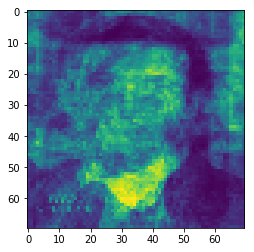

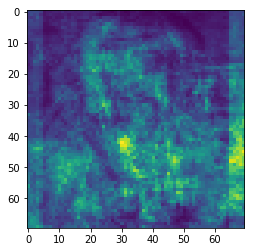

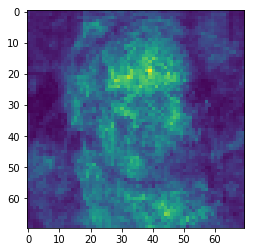

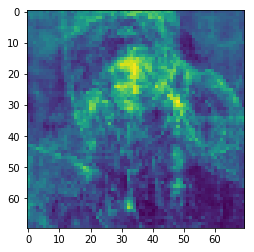

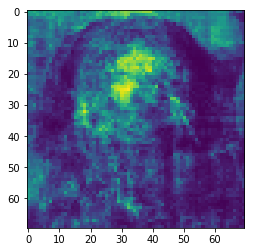

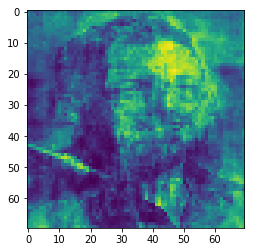

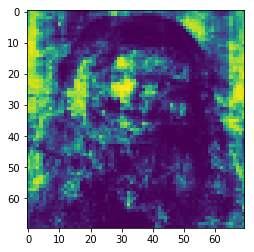

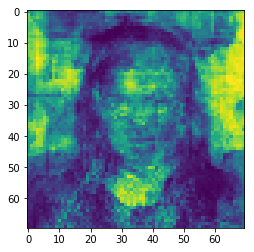

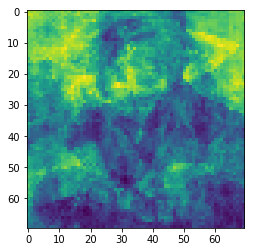

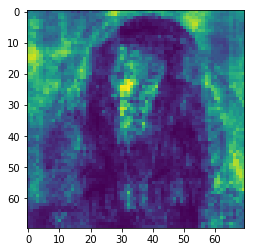

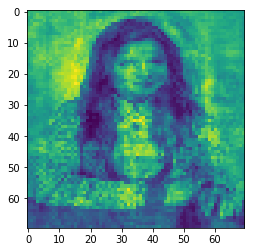

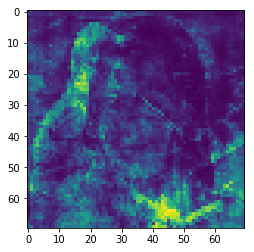

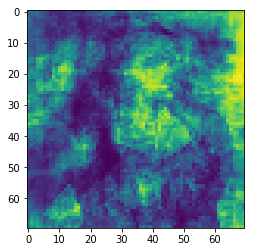

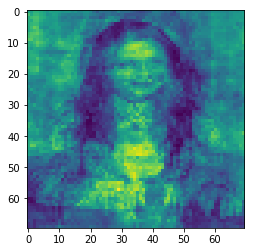

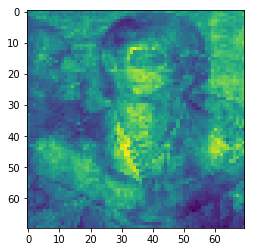

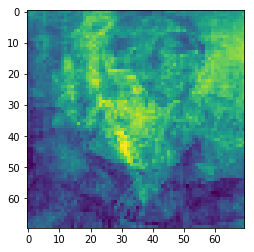

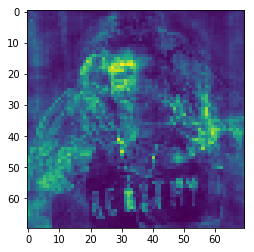

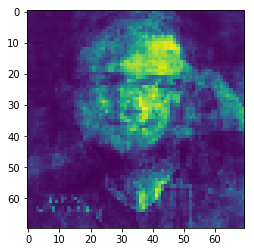

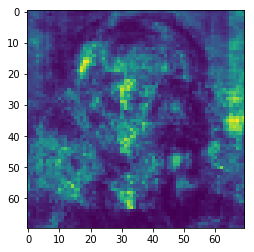

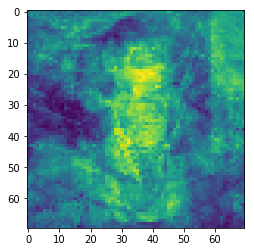

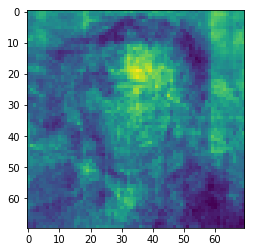

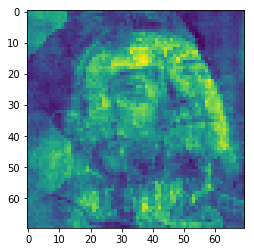

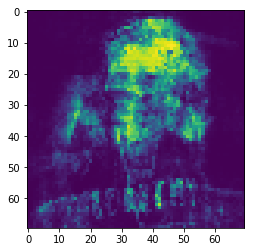

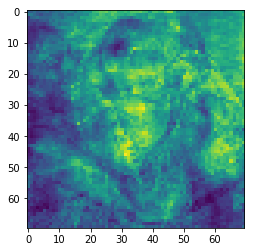

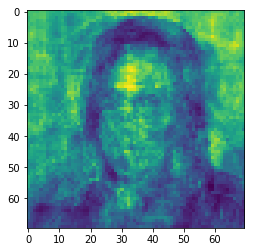

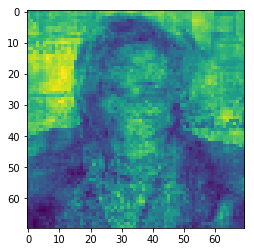

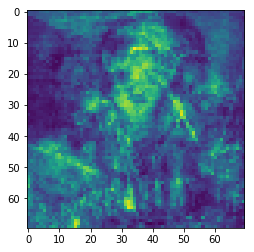

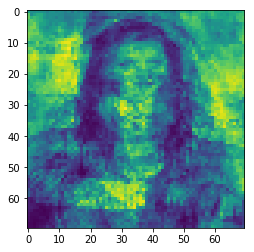

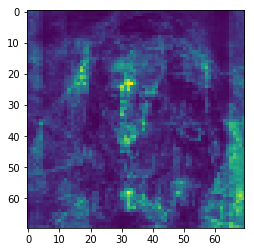

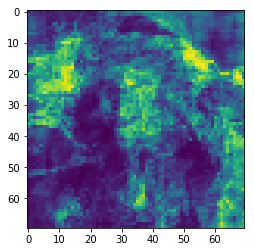

In [24]:
# Results after 150 epochs of training from 93 images 

vae_img = VAE(x_train_img, 1, 150, 4900, 10, 100)
vae_img.fit()

for i in range(30):
    z_test = np.random.randn(1,10)
    pred = vae.predict(z_test)
    pred = pred.reshape((70, 70))
    plt.imshow(pred)
    plt.show()

#### Sound generation 

In [ ]:
vae_music = VAE(x_train_mus, 1, 100, 30000, 100, 100)
vae_music.fit()
z_test = np.random.randn(1,100)
pred = vae_music.predict(z_test) 
pred = pred[0] 
wavfile.write("pred1_fc_100epochs.wav", 30000, pred)

In [148]:
IPython.display.Audio('data/music_train/140bpmmovinbeat.wav')

In [54]:
IPython.display.Audio('data/music_train/80_HH_Groove_38.wav')

In [137]:
IPython.display.Audio('pred1_fc_100epochs.wav')

In [138]:
IPython.display.Audio('pred2_fc_300epochs.wav')